In [1]:
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem

import sys
sys.path.insert(1, '/raid6/homes/kierannp/projects/deep-protein')
from dprotein.utils import *

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from bayes_opt import BayesianOptimization
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, DotProduct, ConstantKernel
import plotly.express as px

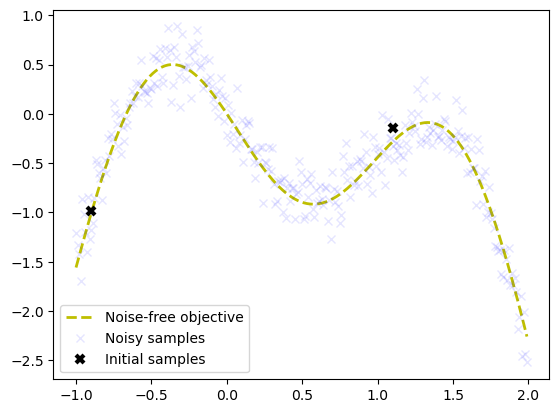

In [16]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

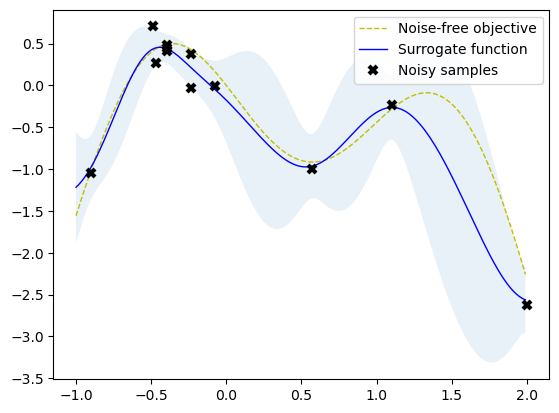

In [17]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)


from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='LCB',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

In [5]:
df = process_results(sim_path = '/raid6/homes/kierannp/projects/deep-protein/sandbox')
# df = df.drop(36)
df = df.dropna()

gp = GaussianProcessRegressor(
    RationalQuadratic(alpha=1, length_scale=1)+DotProduct(),
    normalize_y=False,
    n_restarts_optimizer=5,
    random_state=123,
)
gp.fit(df.loc[:,['hbd','h2o']].values, df.loc[:,'rg'].values)

nx, ny = (100, 100)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)

plot_data = {
    'hbd':xv.flatten(),
    'hba':np.ones(100**2) - xv.flatten() - yv.flatten(),
    'h2o':yv.flatten(),
    'rg': gp.predict(np.concatenate((xv.flatten().reshape(-1,1), yv.flatten().reshape(-1,1)), axis=1))
}
fig = px.scatter_ternary(
    plot_data, 
    a="hbd", 
    b="hba", 
    c="h2o", 
    color='rg',
    labels={
        "hbd": "Urea (Percent)",
        "hba": "Choline Chloride (Percent)",
        "h2o": "Water (Percent)"
    },
    color_continuous_scale = 'Jet'
)
fig.show()
fig = px.scatter_ternary(
    df, 
    a="hbd", 
    b="hba", 
    c="h2o", 
    color='rg',
    labels={
        "hbd": "Urea (Percent)",
        "hba": "Choline Chloride (Percent)",
        "h2o": "Water (Percent)"
    },
    color_continuous_scale = 'Jet'
)
fig.show()

plot_data = {
    'hbd':xv.flatten(),
    'hba':np.ones(100**2) - xv.flatten() - yv.flatten(),
    'h2o':yv.flatten(),
    'std': gp.predict(np.concatenate((xv.flatten().reshape(-1,1), yv.flatten().reshape(-1,1)), axis=1), return_std=True)[1]
}
fig = px.scatter_ternary(
    plot_data, 
    a="hbd", 
    b="hba", 
    c="h2o", 
    color='std',
    labels={
        "hbd": "Urea (Percent)",
        "hba": "Choline Chloride (Percent)",
        "h2o": "Water (Percent)"
    },
    color_continuous_scale = 'Jet'
)
fig.show()

/raid6/homes/kierannp/.conda/envs/deep-protein/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/raid6/homes/kierannp/.conda/envs/deep-protein/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



In [8]:
process_results('/raid6/homes/kierannp/projects/deep-protein/sandbox')

ValueError: too many values to unpack (expected 2)

In [3]:
def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()

hbd       hba       h2o        rg
0   0.497182  0.216679  0.286139  1.412860
1   0.101785  0.346900  0.551315  1.439103
2   0.415057  0.161837  0.423106  1.423702
3   0.309108  0.006063  0.684830  1.434672
4   0.292350  0.315532  0.392118  1.420598
5   0.092984  0.177966  0.729050  1.423567
6   0.412399  0.527923  0.059678  1.411236
7   0.104289  0.157715  0.737995  1.454399
8   0.150473  0.674075  0.175452  1.397745
9   0.248858  0.219315  0.531828  1.425854
10  0.214801  0.176534  0.608665  1.428531
11  0.314511  0.370031  0.315458  1.429578
12  0.103732  0.723571  0.172698  1.410809
13  0.052374  0.671686  0.275940  1.414784
14  0.004939  0.106527  0.888534  1.435644
15  0.133350  0.663362  0.203288  1.427861
16  0.007400  0.218800  0.773801  1.433118
17  0.200867  0.272591  0.526542  1.427029
18  0.251701  0.185457  0.562842  1.427459
19  0.061751  0.029888  0.908361  1.473621
20  0.396767  0.375992  0.227241  1.427852
21  0.174266  0.181103  0.644631  1.423221
22  0.384032  0.201102  0.414866  1.402342
23  0.025037  0.128455  0.846508  1.445014
24  0.090532  0.236995  0.672473  1.421629
25  0.052267  0.671691  0.276042  1.391858
26  0.090533  0.238507  0.670960  1.437616
27  0.152068  0.672379  0.175552  1.393719
28  0.155669  0.504600  0.339732  1.401739
36  0.983792  0.008300  0.007908  2.088608
37  0.000037  0.005513  0.994450  1.470057
38  0.000000  0.000000  1.000000  1.453126
39  0.001958  0.000020  0.998023  1.453493
40  0.000037  0.003891  0.996073  1.469497
41  0.000141  0.006998  0.992861  1.450280
42  0.000014  0.000900  0.999086  1.438743
43  0.008448  0.989218  0.002334  1.413878
44  0.000024  0.006274  0.993702  1.457216

In [14]:
import sys
from bayes_opt import BayesianOptimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from bayes_opt import BayesianOptimization
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, DotProduct

sys.path.insert(1, '~/projects/deep-protein')
from dprotein import *
from dprotein.utils import *

pbounds = {'donor_percent': (0, 1), 'h2o_percent': (0, 1)}

gp = GaussianProcessRegressor(
    RationalQuadratic(alpha=1)+DotProduct(),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=123,
)
df = process_results(sim_path = '/raid6/homes/kierannp/projects/deep-protein/sandbox')
df = df.assign(unnorm_hbd = lambda x: x['hbd']/(1-x['h2o']))
gp.fit(df.loc[:,['unnorm_hbd','h2o']].values, df.loc[:,'rg'].values)

optimizer = BayesianOptimization(
    f=process_results,
    pbounds=pbounds,
    random_state=123,
)

optimizer._gp = GaussianProcessRegressor(
    kernel=RationalQuadratic(alpha=1)+DotProduct(),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=123,
)
params = gp.get_params()
optimizer.set_gp_params(**params)

/raid6/homes/kierannp/.conda/envs/deep-protein/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



In [6]:
from skopt import gp_minimize
import sys
from bayes_opt import BayesianOptimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from bayes_opt import BayesianOptimization
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, DotProduct

sys.path.insert(1, '/raid6/homes/kierannp/projects/deep-protein/')
from dprotein import *
from dprotein.utils import *



repo_path = '/raid6/homes/kierannp/projects/deep-protein/'

# Bounded region of parameter space
pbounds = {'donor_percent': (0, 1), 'h2o_percent': (0, 1)}
gyration_data = {}

simulation = Deep_Eutectic_Search(
    pdb_file = repo_path + 'data/pdbs/proteins/1OIL_A_no_CAL.pdb',
    hba_file_1 = repo_path + 'data/pdbs/HBA/choline.pdb',
    hba_file_2 = repo_path + 'data/pdbs/HBA/cla.pdb',
    hbd_file = repo_path + 'data/pdbs/HBD/urea.pdb',
    h2o_file = repo_path + 'data/pdbs/water.pdb',
    working_dir = repo_path + 'sandbox',
    charges = {'hba_1' : 1, 'hba_2' : -1, 'hbd' : 0, 'protein' : -4},
    total_solvent_mols = 1750
)

def run_simulation(donor_percent, h2o_percent):
    simulation.build_system(
        donor_percent = donor_percent,
        h2o_percent = h2o_percent
    )
    simulation.apply_forcefield()
    simulation.run_sim(
        em_mdp = repo_path + 'mdps/em.mdp',
        nvt_mdp = repo_path + 'mdps/nvt.mdp',
        npt_mdp = repo_path + 'mdps/npt_373.mdp',
        production_mdp = repo_path + 'mdps/production_5ns.mdp'
    )
    return simulation.analyze_trajectory()



gp = GaussianProcessRegressor(
    RationalQuadratic(alpha=1)+DotProduct(),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=123,
)
df = process_results(sim_path = '/raid6/homes/kierannp/projects/deep-protein/sandbox')
df = df.assign(unnorm_hbd = lambda x: x['hbd']/(1-x['h2o']))
gp.fit(df.loc[:,['unnorm_hbd','h2o']].values, df.loc[:,'rg'].values)

res = gp_minimize(
                  run_simulation,                  # the function to minimize
                  [(0., 1.), (0., 1.)],      # the bounds on each dimension of x
                  base_estimator = gp,
                  acq_func = "EI",      # the acquisition function
                  n_calls = 10,         # the number of evaluations of f
                  n_random_starts = None,  # the number of random initialization points
                  noise = 0.1**2,       # the noise level (optional)
                  random_state = 1234)   # the random seed


/raid6/homes/kierannp/.conda/envs/deep-protein/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


TypeError: run_simulation() missing 1 required positional argument: 'h2o_percent'

In [6]:
def load_cosmo(filepath):
    with open(filepath) as f:
        lines = f.readlines()
        f.close()
    charges, xs, ys, zs = [], [], [], []
    for l in lines[2:]:
        _, x, y, z, charge = l.split()
        charges.append(charge)
        xs.append(x)
        ys.append(y)
        zs.append(z)
    xs = [float(i) for i in xs]
    ys = [float(i) for i in ys]
    zs = [float(i) for i in zs]
    charges = [float(i) for i in charges]
    return charges, xs, ys, zs

def plot_cosmo(xs, ys, zs, charges):
    df = pd.DataFrame({'x':xs, 'y':ys, 'z':zs, 'charge':charges})
    sizes = [10] * len(xs)
    fig = go.Figure(data = [go.Scatter3d(x = df['x'],
                                    y = df['y'],
                                    z = df['z'],
                                    mode ='markers', 
                                    marker = dict(
                                        size = 12,
                                        color = df['charge'],
                                        colorscale ='Jet',
                                        opacity = 0.8
                                    )
    )])

    fig.show()

charges, xs, ys, zs = load_cosmo('cosmo.cosmo.xyz')
plot_cosmo(xs, ys, zs, charges)

FileNotFoundError: [Errno 2] No such file or directory: 'cosmo.cosmo.xyz'